### 1. Load a picture
（Taking the astronaut in skimage library as an example）

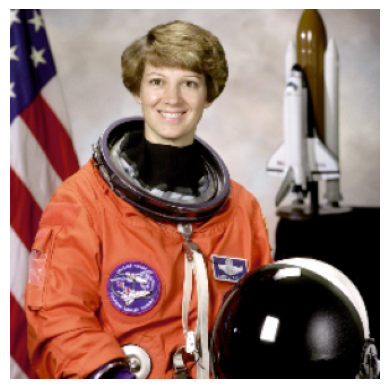

In [1]:
from skimage.data import astronaut
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

img = img_as_float(astronaut()[::2, ::2])
img = resize(img, (299, 299))
img = np.array([img])

plt.imshow(img[0])
plt.axis('off')
plt.show()

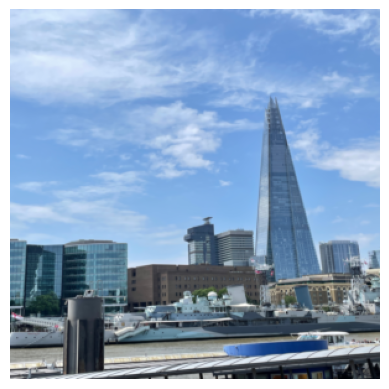

In [2]:
import skimage
image = skimage.io.imread('data/times.jpeg')
image = img_as_float(image)
image = resize(image, (299, 299))
image1 = np.array([image])

plt.axis('off')
plt.imshow(image1[0])
plt.show()

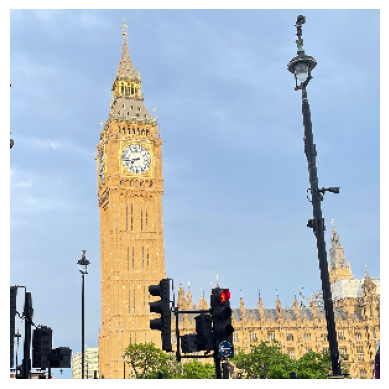

In [4]:
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn(['data/bigBen.jpeg'])

plt.axis('off')
plt.imshow(images[0]/2+0.5)
plt.show()

### 2. Get the predict

In [5]:
from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions

inet_model = inc_net.InceptionV3()

preds = inet_model.predict(image1)
for x in decode_predictions(preds)[0]:
    print(x)

print('==============================')

preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

print('==============================')

preds = inet_model.predict(img)
for x in decode_predictions(preds)[0]:
    print(x)


2023-01-31 19:24:53.609123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 19:24:57.388650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


('n03837869', 'obelisk', 0.79565173)
('n02825657', 'bell_cote', 0.029063663)
('n04483307', 'trimaran', 0.021474903)
('n04355338', 'sundial', 0.0196215)
('n03933933', 'pier', 0.013422327)
('n02825657', 'bell_cote', 0.8818358)
('n02708093', 'analog_clock', 0.03753584)
('n03877845', 'palace', 0.009147308)
('n03903868', 'pedestal', 0.0035486843)
('n04548280', 'wall_clock', 0.0033412874)
('n03379051', 'football_helmet', 0.5395003)
('n03127747', 'crash_helmet', 0.08094214)
('n02790996', 'barbell', 0.0383344)
('n02860847', 'bobsled', 0.030651012)
('n04192698', 'shield', 0.029816164)


We now have gotten 5 explainations.  The first two are both understood for there is a helmet in the picture indeed.  But we cannot find the relationship with the third predict and picture.  LIME is prepared for this.

### 3.LIME
### 3.1 Super piexl
Before applying lime, let me talk about some basic introduce about super pixel. Super pixel is appled in LIME for it can explain which part of the picture support which predict intuitively. LIME mainly uses segmentation and mark_boundaries to obtain super pixels.<br>
See the examples below:
(The following example are modified from skimage documentation. For details, such as difference with (felzenszwalb, slic, quickshift, watershed), visit https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py)

Felzenszwalb number of segments: 257
SLIC number of segments: 153
Quickshift number of segments: 56


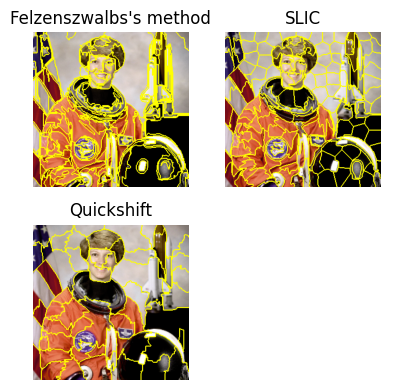

In [6]:
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries

segments_fz = felzenszwalb(img[0], scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img[0], n_segments=200, compactness=10, sigma=1,start_label=1)
segments_quick = quickshift(img[0], kernel_size=4, max_dist=200, ratio=0.2)
gradient = sobel(rgb2gray(img[0]))

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0, 0].imshow(mark_boundaries(img[0], segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img[0], segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img[0], segments_quick))
ax[1, 0].set_title('Quickshift')

for a in ax.ravel():
    a.set_axis_off()


plt.tight_layout()
plt.show()


### 3.2 Apply LIME

In [7]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
x = img[0].astype(np.double)
explanation = explainer.explain_instance(x, inet_model.predict)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Get the explaination for barbell.

The following picture expains the predict for barbell.


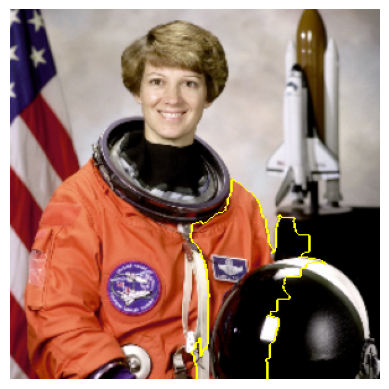

In [8]:
from skimage.segmentation import mark_boundaries

index = 2

print(f'The following picture expains the predict for {decode_predictions(preds)[0][index][1]}.')
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index])

plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

### 3.3 Play around LIME
3.3.1 Select the number of features:


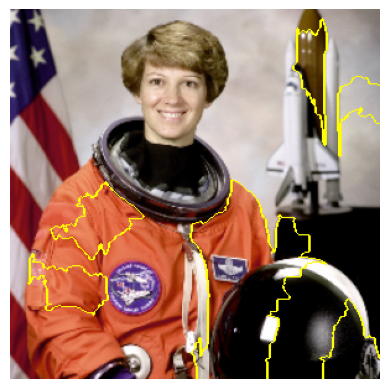

In [9]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index], num_features=10)

plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

3.3.2 Hide the rest.

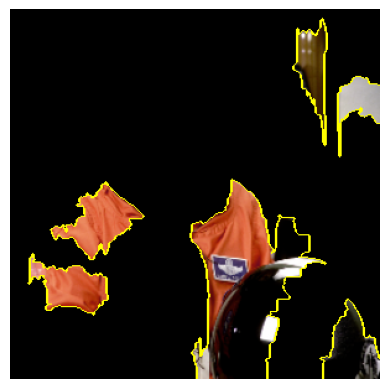

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index], num_features=10,hide_rest=True)

plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


3.3.3 show the pros and cons for the selected predict. (green for pros and red for cons)

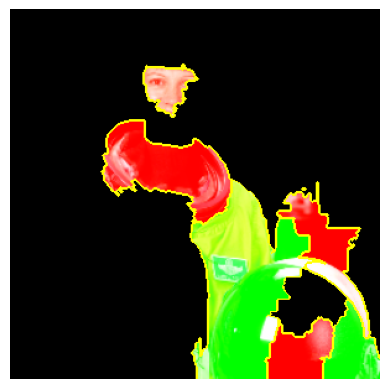

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index],num_features=10,hide_rest=True, positive_only=False)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


3.3.4 Only shows the super pixel with weight larger than 0.02

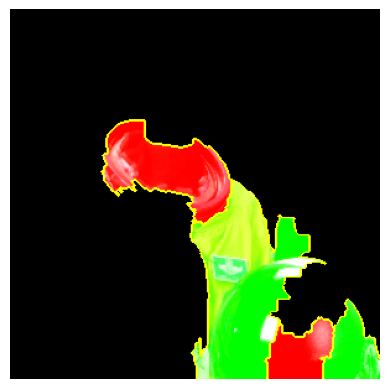

In [12]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index],num_features=10,hide_rest=True, positive_only=False,min_weight=0.02)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

In [ ]:
print(23123123)
print(23213)
